# Packages

In [301]:
import numpy as np
import pandas as pd #for loading csv Excel files
import itertools #to merge lists
from scipy.interpolate import interp1d
from scipy.optimize import leastsq, curve_fit #for fitting
import matplotlib.pyplot as pl #for plots
from matplotlib import rc, rcParams

# Options for plotting

In [198]:
fontsize=26
legendfontsize=22
font = {'size' : fontsize}
rc('font',**font)
rc('text', usetex=True)
rc('font', family='serif', serif='Computer Modern Roman')

In [199]:
#Color palette accessible to colorblind people (see https://davidmathlogic.com/colorblind/)
lightblue='#1A85FF'
blue='#005AB5'
darkblue='#222255'
purple='#5D3A9B'
magenta='#AA4499'
red='#DC3220'
orange='#E66100'
yellow='#FFC20A'
green='#40B0A6'

colors=[lightblue,blue,darkblue,purple,magenta,red,orange,yellow,green]

# Constants

In [288]:
c=2.99792458*10.**8.*10.**(-3.) #km/s (not m/s)
GeV_to_cmminus1=5.068*10.**13.
GeV_to_g=1.78*10.**(-24.)
fm_to_cm=10.**(-15.)*10.**2.

In [274]:
fm_to_cm

1e-13

# Data dark photon model

In [8]:
potentials=['attractive','repulsive'] 
datadarkphotonmodel=np.array([pd.read_csv('DataDarkPhotonModel/crosssec_'+str(potential)+'.csv',header=-1).values for potential in potentials]) #header=-1 needed to load da a from first line.
avals=np.array(datadarkphotonmodel[0][:,0]) #Same avals for both potentials.
#print(avals) 
uniqueavals=np.unique(avals)
#print(uniqueavals)
bvals=np.array(datadarkphotonmodel[0][:,1]) #Same bvals for both potentials.
#print(bvals) 
uniquebvals=np.unique(bvals)
#print(uniquebvals)
print(len(uniquebvals))
cvals=[datadarkphotonmodel[i][:,2] for i in range(0,len(datadarkphotonmodel))]
#print(cvals) 

1001


# Generate 2D interpolation function c(a,b)

In [190]:
#_____Extract lines in data dark photon model with same bvals (repeat each other)_____
ibvals=np.array([list(itertools.chain.from_iterable(np.argwhere(bvals==uniquebvals[i]))) for i in range(0,len(uniquebvals))])
#print(ibvals[0])
#_____For fixed b interpolate in terms of a: c(a)_____
###Note: Small, negligible differences between linear and cubic interpolation function. Interpolation function might break down when extrapolating to values far outside the range of [a,b]. 
#caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='linear') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='cubic',fill_value='extrapolate') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
#print(caint)

In [162]:
#_____2D interpolation function c(a,b)_____
def cab(potential,a,b):
    if potential=='attractive':
        caInt=caint[0]
    elif potential=='repulsive':
        caInt=caint[1]
    #_____Evaluate all interpolation functions c(b) at b and interpolate in terms of a: c(a,b)_____
    cavals=[caInt[i](a) for i in range(0,len(caInt))]
    cab=interp1d(uniquebvals,cavals,kind='cubic',fill_value='extrapolate')(b) #,kind='cubic',fill_value='extrapolate'
    return cab
    
for potential in ['attractive']: #['attractive','repulsive']:
    for b in [0.1]: #[0.1,10.,100.,1000.,10000.]
        for a in [avals[0],avals[1],10**(-10.)]:
            print([a,b,cab(potential,a,b)])

[1e-05, 0.1, array(1.10814e-14)]
[1.05925e-05, 0.1, array(1.24335e-14)]
[1e-10, 0.1, array(-5.79385703e-16)]


# sigmaT(v)

In [214]:
def sigmaT(potential,alphaX,mX,mphi,v):
    a=(1/(2.*alphaX))*(v/c) #Divide by c to make a dimensionless. Ok.
    b=alphaX*(mX/mphi)
    #print('[a,b]='+str([a,b]))
    sigmaT=(16.*np.pi*cab(potential,a,b))/((mX*GeV_to_cmminus1)**2.*(v**2/c**2.)) #cm**2
    return sigmaT

def sigmaT_over_m(potential,alphaX,mX,mphi,v):
    sigmaT_over_m=sigmaT(potential,alphaX,mX,mphi,v)/(mX*GeV_to_g) #cm**2/g
    return sigmaT_over_m

def sigmaT_times_m2(potential,alphaX,mX,mphi,v):
    sigmaT_times_m2=sigmaT_over_m(potential,alphaX,mX,mphi,v)*mX**3. #cm**2/g*GeV**3.
    return sigmaT_times_m2

for potential in ['attractive']: #['attractive','repulsive']:
    for alphaX in [10.**(-2.)]:
        for mX in [200]: #GeV
            for mphi in [10**(-3.)]: #GeV.
                for v in [1000]: #km/s
                    print('sigmaT [cm^2]='+str(sigmaT(potential,alphaX,mX,mphi,v)))
                    print('sigmaT/m [cm^2/g]='+str(sigmaT_over_m(potential,alphaX,mX,mphi,v)))
                    print('sigmaT*m [(cm^2/g) GeV^3]='+str(sigmaT_times_m2(potential,alphaX,mX,mphi,v)))

sigmaT [cm^2]=5.269668738050891e-20
sigmaT/m [cm^2/g]=148.02440275423854
sigmaT*m [(cm^2/g) GeV^3]=1184195222.0339084


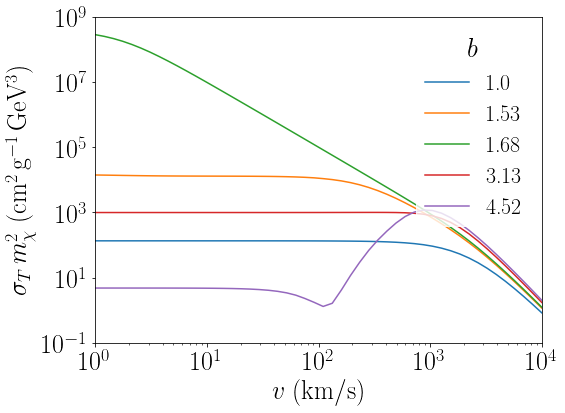

In [222]:
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.

pl.figure(figsize=(8,6))
for b in [1.00,1.53,1.68,3.13,4.52]:
    mphi=(alphaX*mX)/b
    #print(mphi)
    vvals=np.logspace(np.log10(1.),np.log10(10.**4.),50)
    sigmavals=[sigmaT_times_m2(potential,alphaX,mX,mphi,v) for v in vvals]
    pl.plot(vvals,sigmavals,label=str(b))

pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
pl.ylim([0.1,10.**9.])
pl.xlabel(r'$v\;{\rm (km/s)}$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_T \, m_{\chi}^{2}\;{\rm (cm^{2}\,g^{-1}\,GeV^{3})}$',fontsize=fontsize) 
pl.legend(title=r'$b$',loc='upper right',edgecolor='white',fontsize=legendfontsize)
pl.show() #Ok. In accordance with Fig. 3 in Sean's paper 1302.3898.

# Parameterization of sigmaT(v) from Chu et al., 1908.06067

In [290]:
def sigmaTChu(mX,v,aa,re):
    A=mX*(aa*fm_to_cm*GeV_to_cmminus1)*(v/c) #aa in GeV**(-1.)
    B=re/aa #re in GeV**(-1.)
    term1=(1-(1./8.)*B*A**2.)**2.
    term2=(1./4.)*A**2.
    #print('[A,B,term1,term2]='+str([A,B,term1,term2]))
    sigmaT=4.*np.pi*(aa*fm_to_cm)**2.*(term1+term2)**(-1.)
    return sigmaT

def sigmaT_over_mChu(mX,v,aa,re):
    sigmaT_over_m=sigmaTChu(mX,v,aa,re)/(mX*GeV_to_g) #cm**2/g
    return sigmaT_over_m

def sigmaT_times_m2Chu(mX,v,aa,re):
    sigmaT_times_m2=sigmaT_over_mChu(mX,v,aa,re)*mX**3. #cm**2/g*GeV**3.
    return sigmaT_times_m2

for mX in [200]: #GeV
    for v in [10.]: #km/s
        for aa in [10]: #fm
            for re in [1.]: #fm
                print('sigmaT [cm^2]='+str(sigmaTChu(mX,v,aa,re)))
                print('sigmaT/m [cm^2/g]='+str(sigmaT_over_mChu(mX,v,aa,re)))
                print('sigmaT*m [(cm^2/g) GeV^3]='+str(sigmaT_times_m2Chu(mX,v,aa,re)))

sigmaT [cm^2]=1.22512412437e-23
sigmaT/m [cm^2/g]=0.0344135989991
sigmaT*m [(cm^2/g) GeV^3]=9.80099299493e-17


# Fit of Sean's cross section data with parameterization of Chu

In [382]:
vvals=np.logspace(np.log10(1.),np.log10(10.**4.),1000)
print(vvals)

[1.00000000e+00 1.00926219e+00 1.01861017e+00 1.02804473e+00
 1.03756668e+00 1.04717682e+00 1.05687597e+00 1.06666496e+00
 1.07654461e+00 1.08651577e+00 1.09657929e+00 1.10673602e+00
 1.11698682e+00 1.12733256e+00 1.13777413e+00 1.14831241e+00
 1.15894830e+00 1.16968270e+00 1.18051653e+00 1.19145070e+00
 1.20248614e+00 1.21362380e+00 1.22486461e+00 1.23620954e+00
 1.24765955e+00 1.25921561e+00 1.27087871e+00 1.28264983e+00
 1.29452998e+00 1.30652016e+00 1.31862140e+00 1.33083472e+00
 1.34316117e+00 1.35560179e+00 1.36815763e+00 1.38082977e+00
 1.39361927e+00 1.40652724e+00 1.41955477e+00 1.43270295e+00
 1.44597292e+00 1.45936580e+00 1.47288272e+00 1.48652484e+00
 1.50029332e+00 1.51418933e+00 1.52821404e+00 1.54236865e+00
 1.55665436e+00 1.57107239e+00 1.58562396e+00 1.60031031e+00
 1.61513269e+00 1.63009236e+00 1.64519059e+00 1.66042866e+00
 1.67580786e+00 1.69132952e+00 1.70699493e+00 1.72280545e+00
 1.73876240e+00 1.75486715e+00 1.77112106e+00 1.78752553e+00
 1.80408193e+00 1.820791

In [363]:
def sigmaTChu(mX,v,aa,ratio):
    A=mX*(aa*fm_to_cm*GeV_to_cmminus1)*(v/c) #aa in GeV**(-1.)
    B=ratio
    #B=re/aa #re in GeV**(-1.)
    term1=(1-(1./8.)*B*A**2.)**2.
    term2=(1./4.)*A**2.
    #print('[A,B,term1,term2]='+str([A,B,term1,term2]))
    sigmaT=4.*np.pi*(aa*fm_to_cm)**2.*(term1+term2)**(-1.)
    return sigmaT

def sigmaT_over_mChu(mX,v,aa,ratio):
    sigmaT_over_m=sigmaTChu(mX,v,aa,ratio)/(mX*GeV_to_g) #cm**2/g
    return sigmaT_over_m

def sigmaT_times_m2Chu(mX,v,aa,ratio):
    sigmaT_times_m2=sigmaT_over_mChu(mX,v,aa,ratio)*mX**3. #cm**2/g*GeV**3.
    return sigmaT_times_m2

for mX in [10**2.]: #GeV
    for v in [10.]: #km/s
        for aa in [10.]: #fm
            for ratio in [-1.]: 
                print('sigmaT [cm^2]='+str(sigmaTChu(mX,v,aa,ratio)))
                print('sigmaT/m [cm^2/g]='+str(sigmaT_over_mChu(mX,v,aa,ratio)))
                print('sigmaT*m [(cm^2/g) GeV^3]='+str(sigmaT_times_m2Chu(mX,v,aa,ratio)))

sigmaT [cm^2]=1.23891834839e-23
sigmaT/m [cm^2/g]=0.0696021544039
sigmaT*m [(cm^2/g) GeV^3]=69602.1544039


In [383]:
potential='attractive'
alphaX=10.**(-2.)
mX=100. #GeV
#b=4.52
#mphi=(alphaX*mX)/b
mphi=1. #GeV
print('mphi='+str(mphi))

sigmaT_times_m2vals=np.array([sigmaT_times_m2(potential,alphaX,mX,mphi,v) for v in vvals])

def sigmaT_times_m2Chufit(vvals,aa,ratio):
    sigmaT_times_m2valsChu=np.array([sigmaT_times_m2Chu(mX,v,aa,ratio) for v in vvals])
    return sigmaT_times_m2valsChu

popt, pcov =curve_fit(sigmaT_times_m2Chufit,vvals,sigmaT_times_m2vals)
print(popt, pcov)
[aa,ratio]=popt
re=ratio*aa
sigmaT_times_m2valsChu=np.array([sigmaT_times_m2Chu(mX,v,aa,ratio) for v in vvals])
chi2=sum(np.array(sigmaT_times_m2vals-sigmaT_times_m2valsChu)**2.)
print('[aa,ratio,re,chi2]='+str([aa,ratio,re,chi2]))

mphi=1.0
(array([ 0.43418613, -1.93494387]), array([[ 4.80120110e-10, -9.11311449e-09],
       [-9.11311449e-09,  4.89489823e-06]]))
[aa,ratio,re,chi2]=[0.434186127693167, -1.9349438743493315, -0.8401257881073502, 121.19916682178544]


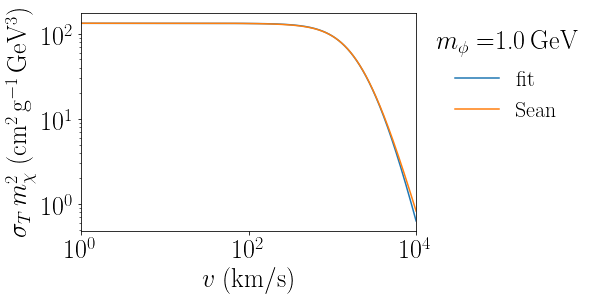

In [385]:
pl.plot(vvals,sigmaT_times_m2valsChu,label='fit')
pl.plot(vvals,sigmaT_times_m2vals,label='Sean')
pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
#pl.ylim([0.1,10.**9.])
pl.xlabel(r'$v\;{\rm (km/s)}$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_T \, m_{\chi}^{2}\;{\rm (cm^{2}\,g^{-1}\,GeV^{3})}$',fontsize=fontsize) 
pl.legend(title=r'$m_{\phi}=$'+str(mphi)+r'$\,{\rm GeV}$',bbox_to_anchor=[1.,1.],edgecolor='white',fontsize=legendfontsize)
pl.show()

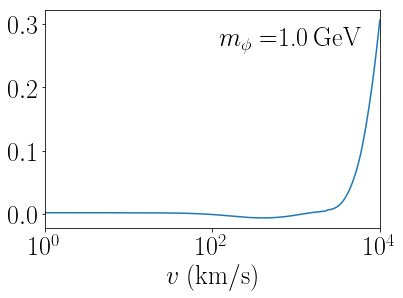

In [388]:
pl.plot(vvals,(sigmaT_times_m2vals-sigmaT_times_m2valsChu)/sigmaT_times_m2valsChu)
pl.xscale('log')
#pl.yscale('log')
pl.xlim([1,10.**4.])
#pl.ylim([0.1,10.**9.])
pl.xlabel(r'$v\;{\rm (km/s)}$',fontsize=fontsize) 
#pl.ylabel(r'$\sigma_{T\,{\rm Sean}}-\sigma_{T\,{\rm Chu}} \, m_{\chi}^{2}\;{\rm (cm^{2}\,g^{-1}\,GeV^{3})}$',fontsize=fontsize) 
pl.legend(title=r'$m_{\phi}=$'+str(mphi)+r'$\,{\rm GeV}$',bbox_to_anchor=[1.,1.],edgecolor='white',fontsize=legendfontsize)
pl.show()

In [389]:
potential='attractive'
alphaX=10.**(-2.)
mX=100. #GeV
#b=4.52
#mphi=(alphaX*mX)/b
mphi=0.001 #GeV
print('mphi='+str(mphi))

sigmaT_times_m2vals=np.array([sigmaT_times_m2(potential,alphaX,mX,mphi,v) for v in vvals])

def sigmaT_times_m2Chufit(vvals,aa,ratio):
    sigmaT_times_m2valsChu=np.array([sigmaT_times_m2Chu(mX,v,aa,ratio) for v in vvals])
    return sigmaT_times_m2valsChu

popt, pcov =curve_fit(sigmaT_times_m2Chufit,vvals,sigmaT_times_m2vals,bounds=((0.,100.)),max_nfev=100)
print(popt, pcov)
[aa,ratio]=popt
re=ratio*aa
sigmaT_times_m2valsChu=np.array([sigmaT_times_m2Chu(mX,v,aa,ratio) for v in vvals])
chi2=sum(np.array(sigmaT_times_m2vals-sigmaT_times_m2valsChu)**2.)
print('[aa,ratio,re,chi2]='+str([aa,ratio,re,chi2]))

mphi=0.001
(array([100.        ,  99.99999991]), array([[ 1336975.25561751, -2714074.39760323],
       [-2714074.39760323,  5538577.44157599]]))
[aa,ratio,re,chi2]=[99.99999999609501, 99.99999991168782, 9999.999990778284, 1.09321228080978e+23]


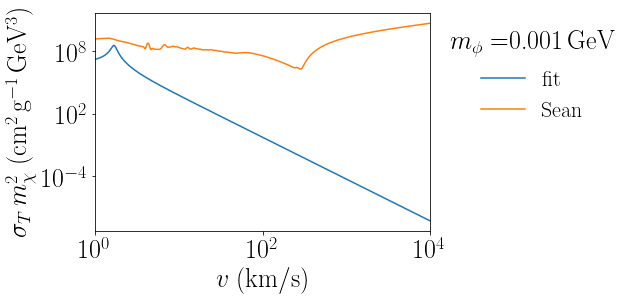

In [390]:
pl.plot(vvals,sigmaT_times_m2valsChu,'.'.label='fit')
pl.plot(vvals,sigmaT_times_m2vals,label='Sean')
pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
#pl.ylim([0.1,10.**9.])
pl.xlabel(r'$v\;{\rm (km/s)}$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_T \, m_{\chi}^{2}\;{\rm (cm^{2}\,g^{-1}\,GeV^{3})}$',fontsize=fontsize) 
pl.legend(title=r'$m_{\phi}=$'+str(mphi)+r'$\,{\rm GeV}$',bbox_to_anchor=[1.,1.],edgecolor='white',fontsize=legendfontsize)
pl.show()

In [376]:
vvals=np.logspace(np.log10(10.**(-2.)),np.log10(10.**2.),1000)
print(vvals)

[1.00000000e-02 1.00926219e-02 1.01861017e-02 1.02804473e-02
 1.03756668e-02 1.04717682e-02 1.05687597e-02 1.06666496e-02
 1.07654461e-02 1.08651577e-02 1.09657929e-02 1.10673602e-02
 1.11698682e-02 1.12733256e-02 1.13777413e-02 1.14831241e-02
 1.15894830e-02 1.16968270e-02 1.18051653e-02 1.19145070e-02
 1.20248614e-02 1.21362380e-02 1.22486461e-02 1.23620954e-02
 1.24765955e-02 1.25921561e-02 1.27087871e-02 1.28264983e-02
 1.29452998e-02 1.30652016e-02 1.31862140e-02 1.33083472e-02
 1.34316117e-02 1.35560179e-02 1.36815763e-02 1.38082977e-02
 1.39361927e-02 1.40652724e-02 1.41955477e-02 1.43270295e-02
 1.44597292e-02 1.45936580e-02 1.47288272e-02 1.48652484e-02
 1.50029332e-02 1.51418933e-02 1.52821404e-02 1.54236865e-02
 1.55665436e-02 1.57107239e-02 1.58562396e-02 1.60031031e-02
 1.61513269e-02 1.63009236e-02 1.64519059e-02 1.66042866e-02
 1.67580786e-02 1.69132952e-02 1.70699493e-02 1.72280545e-02
 1.73876240e-02 1.75486715e-02 1.77112106e-02 1.78752553e-02
 1.80408193e-02 1.820791

In [377]:
potential='attractive'
alphaX=10.**(-2.)
mX=100. #GeV
#b=4.52
#mphi=(alphaX*mX)/b
mphi=1. #GeV
print('mphi='+str(mphi))

sigmaT_times_m2vals=np.array([sigmaT_times_m2(potential,alphaX,mX,mphi,v) for v in vvals])

def sigmaT_times_m2Chufit(vvals,aa,ratio):
    sigmaT_times_m2valsChu=np.array([sigmaT_times_m2Chu(mX,v,aa,ratio) for v in vvals])
    return sigmaT_times_m2valsChu

popt, pcov =curve_fit(sigmaT_times_m2Chufit,vvals,sigmaT_times_m2vals)
print(popt, pcov)
[aa,ratio]=popt
re=ratio*aa
sigmaT_times_m2valsChu=np.array([sigmaT_times_m2Chu(mX,v,aa,ratio) for v in vvals])
chi2=sum(np.array(sigmaT_times_m2vals-sigmaT_times_m2valsChu)**2.)
print('[aa,ratio,re,chi2]='+str([aa,ratio,re,chi2]))

mphi=1.0
(array([ 0.42182547, 83.96480073]), array([[ 1.97953847e-06, -1.42708451e-02],
       [-1.42708451e-02,  8.21572293e+02]]))
[aa,ratio,re,chi2]=[0.4218254724080789, 83.96480073340688, 35.418491735019565, 628989.639856394]


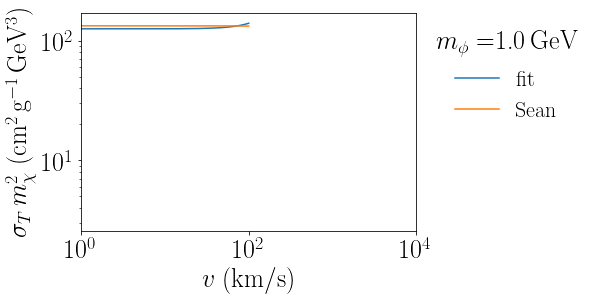

In [378]:
pl.plot(vvals,sigmaT_times_m2valsChu,label='fit')
pl.plot(vvals,sigmaT_times_m2vals,label='Sean')
pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
#pl.ylim([0.1,10.**9.])
pl.xlabel(r'$v\;{\rm (km/s)}$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_T \, m_{\chi}^{2}\;{\rm (cm^{2}\,g^{-1}\,GeV^{3})}$',fontsize=fontsize) 
pl.legend(title=r'$m_{\phi}=$'+str(mphi)+r'$\,{\rm GeV}$',bbox_to_anchor=[1.,1.],edgecolor='white',fontsize=legendfontsize)
pl.show()